# Import Libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [2]:
from choices import param_dict 
from utilities import deets

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


In [3]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

# Load data

In [4]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc' , 
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


In [6]:
from utilities import get_true_data
u_true = get_true_data(u[[]])
x_true = get_true_data(x[[]])

# Classification

## Cross validation

In [16]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

### Train Classifier One Vs Rest

In [17]:
gamma = 0.07
cl_weight = calc_weight(gamma , y)
clf = lgb.LGBMClassifier(n_estimators = 100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM' , clf ,gamma , x,y)
model.validate(k=20)
model.train()


>>> GOING for 1 / 20 Iteration FOLD
>>> GOING for 2 / 20 Iteration FOLD
>>> GOING for 3 / 20 Iteration FOLD
>>> GOING for 4 / 20 Iteration FOLD
>>> GOING for 5 / 20 Iteration FOLD
>>> GOING for 6 / 20 Iteration FOLD
>>> GOING for 7 / 20 Iteration FOLD
>>> GOING for 8 / 20 Iteration FOLD
>>> GOING for 9 / 20 Iteration FOLD
>>> GOING for 10 / 20 Iteration FOLD
>>> GOING for 11 / 20 Iteration FOLD
>>> GOING for 12 / 20 Iteration FOLD
>>> GOING for 13 / 20 Iteration FOLD
>>> GOING for 14 / 20 Iteration FOLD
>>> GOING for 15 / 20 Iteration FOLD
>>> GOING for 16 / 20 Iteration FOLD
>>> GOING for 17 / 20 Iteration FOLD
>>> GOING for 18 / 20 Iteration FOLD
>>> GOING for 19 / 20 Iteration FOLD
>>> GOING for 20 / 20 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.969937 |          0.970343 |   0.97014  |
| CV      |       0.5      |          0.572414 |   0.533762 |
| HMXB    |       0.9

In [30]:
#save later
#model.result['res_table'].to_csv('temp_res_comp/train_prob/none_lightGBM.csv')

In [12]:
#model.train()
#model.save('models/lightGBM-final.pkl')

## Prediction on New sources

In [5]:
import joblib 
model = joblib.load('models/lightGBM-final.pkl')
clf = model.clf

In [6]:
# u = []
# ui = []
# for i in range(8):
#     u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
#     ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
# u = pd.concat(u)
# ui = pd.concat(ui)
ui = pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name')
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
u
u = u.reset_index()
# remove sources which were in training set
u = u[~u['name'].isin(x.index.to_list())].set_index('name')
u

gal_b2    gal_l2  var_inter_prob_b  \
name                                                          
2CXO J004829.5-732959  2.560959  8.422809               NaN   
2CXO J005449.0-725128  2.525176  8.405124               NaN   
2CXO J010049.1-731526  2.548291  8.388764               NaN   
2CXO J010049.8-731045  2.543942  8.388578               NaN   
2CXO J010647.7-730940  2.544536  8.371916               NaN   
...                         ...       ...               ...   
2CXO J220433.1-495916  2.153631  9.602391          6.284069   
2CXO J220508.3-495935  2.148799  9.600738          7.232708   
2CXO J220544.0-495505  2.142337  9.602388          7.905990   
2CXO J220555.6-500837  2.145093  9.592560         10.000000   
2CXO J220603.1-500911  2.144237  9.591859          9.994348   

                       var_inter_sigma_b  var_intra_prob_b  var_inter_index_b  \
name                                                                            
2CXO J004829.5-732959                NaN          2.363359                NaN   
2CXO J005449.0-725128                NaN          0.900227                NaN   
2CXO J010049.1-731526                NaN          2.694112                NaN   
2CXO J010049.8-731045                NaN          3.098912                NaN   
2CXO J010647.7-730940                NaN          9.693387                NaN   
...                                  ...               ...                ...   
2CXO J220433.1-495916           0.008090          0.848783               5.00   
2CXO J220508.3-495935           0.007515          7.897757               6.25   
2CXO J220544.0-495505           0.007822               NaN               6.25   
2CXO J220555.6-500837           0.048010          2.439792              10.00   
2CXO J220603.1-500911           0.015846          8.893080               8.75   

                       kp_intra_prob_b  var_intra_index_b         h-csc  \
name                                                                      
2CXO J004829.5-732959         9.949403                0.0  3.304254e-09   
2CXO J005449.0-725128         1.221561                0.0  4.201018e-07   
2CXO J010049.1-731526         4.333967                0.0  8.611031e-08   
2CXO J010049.8-731045         3.680766                0.0  1.742587e-06   
2CXO J010647.7-730940         9.994160                6.0  5.241312e-08   
...                                ...                ...           ...   
2CXO J220433.1-495916         9.398184                0.0  2.267642e-07   
2CXO J220508.3-495935         9.373067                2.0  8.028243e-08   
2CXO J220544.0-495505              NaN                NaN  1.863801e-07   
2CXO J220555.6-500837         8.743222                0.0  1.682809e-08   
2CXO J220603.1-500911         9.995940                5.0  4.605293e-07   

                          b-csc  ...        Rp       B-R       G-J  G-W2  \
name                             ...                                       
2CXO J004829.5-732959  0.002147  ...       NaN       NaN       NaN   NaN   
2CXO J005449.0-725128  0.011944  ...       NaN       NaN       NaN   NaN   
2CXO J010049.1-731526  0.003832  ...       NaN       NaN       NaN   NaN   
2CXO J010049.8-731045  0.009243  ...       NaN       NaN       NaN   NaN   
2CXO J010647.7-730940  0.003135  ...  7.329417  3.418280       NaN   NaN   
...                         ...  ...       ...       ...       ...   ...   
2CXO J220433.1-495916  0.035677  ...       NaN       NaN       NaN   NaN   
2CXO J220508.3-495935  0.041673  ...       NaN       NaN       NaN   NaN   
2CXO J220544.0-495505  0.016260  ...       NaN       NaN       NaN   NaN   
2CXO J220555.6-500837  0.036317  ...  8.252398  4.009943       NaN   NaN   
2CXO J220603.1-500911  0.032189  ...  5.896753  3.480289  2.341994   NaN   

                           Bp-H  Bp-W3      Rp-K      J-H  J-W1  W1-W2  
name                                                                    
2CXO J004829.5-732959       NaN    NaN  

In [7]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

prob_AGN   prob_CV  prob_HMXB  prob_LMXB  prob_PULSAR  \
2CXO J004829.5-732959  0.006866  0.003271   0.854534   0.000017     0.002261   
2CXO J005449.0-725128  0.008875  0.016311   0.929717   0.000043     0.000785   
2CXO J010049.1-731526  0.008277  0.004818   0.807098   0.000054     0.005160   
2CXO J010049.8-731045  0.040766  0.016721   0.526201   0.000443     0.003861   
2CXO J010647.7-730940  0.004241  0.009808   0.683742   0.002000     0.008044   
...                         ...       ...        ...        ...          ...   
2CXO J220433.1-495916  0.032561  0.233294   0.671695   0.000025     0.000336   
2CXO J220508.3-495935  0.017150  0.063122   0.913425   0.000210     0.000860   
2CXO J220544.0-495505  0.089127  0.091377   0.801407   0.000579     0.000613   
2CXO J220555.6-500837  0.000871  0.008760   0.926816   0.000044     0.000296   
2CXO J220603.1-500911  0.000290  0.000290   0.013500   0.000054     0.000343   

                       prob_STAR  prob_ULX  prob_YSO  
2CXO J004829.5-732959   0.115568  0.017461  0.000021  
2CXO J005449.0-725128   0.043891  0.000347  0.000032  
2CXO J010049.1-731526   0.167167  0.007402  0.000025  
2CXO J010049.8-731045   0.407359  0.004558  0.000092  
2CXO J010647.7-730940   0.291919  0.000168  0.000077  
...                          ...       ...       ...  
2CXO J220433.1-495916   0.007829  0.054160  0.000100  
2CXO J220508.3-495935   0.001775  0.003403  0.000054  
2CXO J220544.0-495505   0.013682  0.003008  0.000208  
2CXO J220555.6-500837   0.000558  0.062627  0.000027  
2CXO J220603.1-500911   0.985432  0.000040  0.000051  

[37873 rows x 8 columns]

In [8]:
u.columns.to_list()

['gal_b2',
 'gal_l2',
 'var_inter_prob_b',
 'var_inter_sigma_b',
 'var_intra_prob_b',
 'var_inter_index_b',
 'kp_intra_prob_b',
 'var_intra_index_b',
 'h-csc',
 'b-csc',
 'm-csc',
 's-csc',
 'u-csc',
 '0p3_8_csc',
 'FUV',
 'NUV',
 'u-sdss',
 'g-sdss',
 'r-sdss',
 'i-sdss',
 'z-sdss',
 'W1',
 'W2',
 'W3',
 'W4',
 '24_microns_(MIPS)',
 'J',
 'H',
 'K',
 'G',
 'Bp',
 'Rp',
 'B-R',
 'G-J',
 'G-W2',
 'Bp-H',
 'Bp-W3',
 'Rp-K',
 'J-H',
 'J-W1',
 'W1-W2']

In [10]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J004829.5-732959  HMXB  0.854534     0.738966  0.006866  0.003271   
2CXO J005449.0-725128  HMXB  0.929717     0.885827  0.008875  0.016311   
2CXO J010049.1-731526  HMXB  0.807098     0.639931  0.008277  0.004818   
2CXO J010049.8-731045  HMXB  0.526201     0.118842  0.040766  0.016721   
2CXO J010647.7-730940  HMXB  0.683742     0.391823  0.004241  0.009808   
...                     ...       ...          ...       ...       ...   
2CXO J220433.1-495916  HMXB  0.671695     0.438401  0.032561  0.233294   
2CXO J220508.3-495935  HMXB  0.913425     0.850303  0.017150  0.063122   
2CXO J220544.0-495505  HMXB  0.801407     0.710030  0.089127  0.091377   
2CXO J220555.6-500837  HMXB  0.926816     0.864189  0.000871  0.008760   
2CXO J220603.1-500911  STAR  0.985432     0.971931  0.000290  0.000290   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J004829.5-732959   0.854534   0.000017     0.002261   0.115568  0.017461   
2CXO J005449.0-725128   0.929717   0.000043     0.000785   0.043891  0.000347   
2CXO J010049.1-731526   0.807098   0.000054     0.005160   0.167167  0.007402   
2CXO J010049.8-731045   0.526201   0.000443     0.003861   0.407359  0.004558   
2CXO J010647.7-730940   0.683742   0.002000     0.008044   0.291919  0.000168   
...                          ...        ...          ...        ...       ...   
2CXO J220433.1-495916   0.671695   0.000025     0.000336   0.007829  0.054160   
2CXO J220508.3-495935   0.913425   0.000210     0.000860   0.001775  0.003403   
2CXO J220544.0-495505   0.801407   0.000579     0.000613   0.013682  0.003008   
2CXO J220555.6-500837   0.926816   0.000044     0.000296   0.000558  0.062627   
2CXO J220603.1-500911   0.013500   0.000054     0.000343   0.985432  0.000040   

                       prob_YSO  
name                             
2CXO J004829.5-732959  0.000021  
2CXO J005449.0-725128  0.000032  
2CXO J010049.1-731526  0.000025  
2CXO J010049.8-731045  0.000092  
2CXO J010647.7-730940  0.000077  
...                         ...  
2CXO J220433.1-495916  0.000100  
2CXO J220508.3-495935  0.000054  
2CXO J220544.0-495505  0.000208  
2CXO J220555.6-500837  0.000027  
2CXO J220603.1-500911  0.000051  

[37873 rows x 11 columns]

#### COnfused sources

In [11]:
conf_src = u_df[u_df['prob_margin']<0.05]
conf_src = conf_src.rename(columns = {
    'prob_AGN' : 'AGN' , 
    'prob_HMXB' : 'HMXB' , 
    'prob_CV' : 'CV' , 
    'prob_LMXB' : 'LMXB' , 
    'prob_STAR' : 'STAR' , 
    'prob_PULSAR' : 'PULSAR' , 
    'prob_ULX' : 'ULX' , 
    'prob_YSO' : 'YSO' , 
})
conf_src_class = conf_src['class']
conf_src = conf_src.drop(columns = ['class' ,'prob' , 'prob_margin'])
conf_src

AGN        CV      HMXB      LMXB    PULSAR  \
name                                                                      
2CXO J170219.5-431454  0.000722  0.181663  0.005083  0.000151  0.366292   
2CXO J171515.1-401413  0.003604  0.454568  0.004489  0.000075  0.427238   
2CXO J180419.3-242413  0.000029  0.000476  0.000140  0.000011  0.000082   
2CXO J180715.0-245655  0.000144  0.498568  0.000231  0.000039  0.020675   
2CXO J180724.9-250124  0.001402  0.343202  0.006159  0.000337  0.008349   
...                         ...       ...       ...       ...       ...   
2CXO J052316.2+333055  0.019455  0.016723  0.004191  0.001303  0.004345   
2CXO J165340.5-395126  0.006081  0.350891  0.182847  0.002978  0.039024   
2CXO J230233.5-385824  0.055311  0.427514  0.071224  0.000317  0.004040   
2CXO J001335.7-231846  0.089713  0.000716  0.446996  0.001434  0.003979   
2CXO J142904.0+154752  0.021612  0.031885  0.373022  0.000144  0.398563   

                           STAR       ULX       YSO  
name                                                 
2CXO J170219.5-431454  0.083838  0.000631  0.361621  
2CXO J171515.1-401413  0.010521  0.000453  0.099052  
2CXO J180419.3-242413  0.502058  0.000008  0.497196  
2CXO J180715.0-245655  0.027110  0.000054  0.453179  
2CXO J180724.9-250124  0.266772  0.000314  0.373464  
...                         ...       ...       ...  
2CXO J052316.2+333055  0.482229  0.002426  0.469329  
2CXO J165340.5-395126  0.368453  0.002275  0.047448  
2CXO J230233.5-385824  0.002715  0.438744  0.000136  
2CXO J001335.7-231846  0.454886  0.001870  0.000406  
2CXO J142904.0+154752  0.003949  0.169144  0.001682  

[937 rows x 8 columns]

In [13]:
img_loc = '../../thesis/final_ppt/images/'

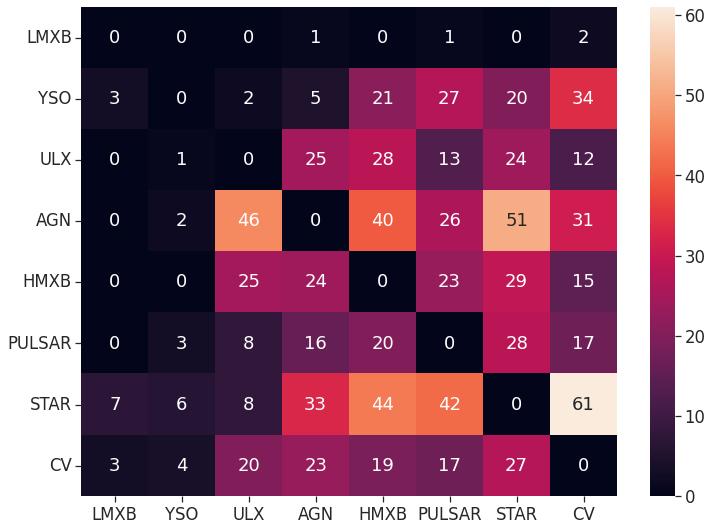

In [16]:
cl1 = []
cl2 = []
from utilities import set_plot
set_plot(font_size=1.5)
for n in conf_src.index.to_list():
    temp = conf_src.loc[n].sort_values(ascending=False).index.to_list()
    cl1.append(temp[1])
    cl2.append(temp[2])
from sklearn.metrics import confusion_matrix 
classes =  ['LMXB' ,'YSO' ,'ULX' , 'AGN' ,'HMXB','PULSAR' ,'STAR'   ,  'CV']
cm = confusion_matrix(cl1 , cl2 , labels =classes , normalize=None)
plt.figure(figsize=(12,9))
sns.heatmap(cm , annot=True , xticklabels = classes , yticklabels = classes , fmt = '.0f')
plt.yticks(rotation=0)
plt.savefig('../../thesis/final_ppt/images/src_confusion.jpg' , format='jpg')
plt.show()

In [17]:
cmdf = pd.DataFrame(cm , index = classes , columns = classes)
cmdf.index.name = 'Highest prob Class'
print(cmdf.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  LMXB &  YSO &  ULX &  AGN &  HMXB &  PULSAR &  STAR &  CV \\
Highest prob Class &       &      &      &      &       &         &       &     \\
\midrule
LMXB               &     0 &    0 &    0 &    1 &     0 &       1 &     0 &   2 \\
YSO                &     3 &    0 &    2 &    5 &    21 &      27 &    20 &  34 \\
ULX                &     0 &    1 &    0 &   25 &    28 &      13 &    24 &  12 \\
AGN                &     0 &    2 &   46 &    0 &    40 &      26 &    51 &  31 \\
HMXB               &     0 &    0 &   25 &   24 &     0 &      23 &    29 &  15 \\
PULSAR             &     0 &    3 &    8 &   16 &    20 &       0 &    28 &  17 \\
STAR               &     7 &    6 &    8 &   33 &    44 &      42 &     0 &  61 \\
CV                 &     3 &    4 &   20 &   23 &    19 &      17 &    27 &   0 \\
\bottomrule
\end{tabular}



In [18]:
from sklearn.preprocessing import MinMaxScaler 

In [19]:
cmdf

LMXB  YSO  ULX  AGN  HMXB  PULSAR  STAR  CV
Highest prob Class                                             
LMXB                   0    0    0    1     0       1     0   2
YSO                    3    0    2    5    21      27    20  34
ULX                    0    1    0   25    28      13    24  12
AGN                    0    2   46    0    40      26    51  31
HMXB                   0    0   25   24     0      23    29  15
PULSAR                 0    3    8   16    20       0    28  17
STAR                   7    6    8   33    44      42     0  61
CV                     3    4   20   23    19      17    27   0

In [20]:
print(u_df.sample(frac=0.001).reset_index().head(15).to_latex(float_format='%.2f' , index=False))

\begin{tabular}{llrrrrrrrrrr}
\toprule
                  name &   class &  prob &  prob\_margin &  prob\_AGN &  prob\_CV &  prob\_HMXB &  prob\_LMXB &  prob\_PULSAR &  prob\_STAR &  prob\_ULX &  prob\_YSO \\
\midrule
 2CXO J101715.6-333336 &     ULX &  0.97 &         0.95 &      0.00 &     0.01 &       0.01 &       0.00 &         0.00 &       0.00 &      0.97 &      0.00 \\
 2CXO J184158.5-282649 &    STAR &  1.00 &         1.00 &      0.00 &     0.00 &       0.00 &       0.00 &         0.00 &       1.00 &      0.00 &      0.00 \\
 2CXO J040814.3-210624 &     AGN &  0.95 &         0.92 &      0.95 &     0.00 &       0.03 &       0.00 &         0.00 &       0.00 &      0.01 &      0.00 \\
 2CXO J041849.9+281949 &     AGN &  0.76 &         0.56 &      0.76 &     0.01 &       0.01 &       0.00 &         0.01 &       0.20 &      0.01 &      0.00 \\
 2CXO J131235.6-624234 &  PULSAR &  0.73 &         0.46 &      0.00 &     0.00 &       0.00 &       0.00 &         0.73 &       0.00 &      0.0

In [21]:
u_df.to_csv('temp_res_comp/unid_prob/lightGBM_none.csv')

In [22]:
u_df = pd.read_csv('temp_res_comp/unid_prob/lightGBM_none.csv' , index_col='name')
u_df

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J004829.5-732959  HMXB  0.854534     0.738966  0.006866  0.003271   
2CXO J005449.0-725128  HMXB  0.929717     0.885827  0.008875  0.016311   
2CXO J010049.1-731526  HMXB  0.807098     0.639931  0.008277  0.004818   
2CXO J010049.8-731045  HMXB  0.526201     0.118842  0.040766  0.016721   
2CXO J010647.7-730940  HMXB  0.683742     0.391823  0.004241  0.009808   
...                     ...       ...          ...       ...       ...   
2CXO J220433.1-495916  HMXB  0.671695     0.438401  0.032561  0.233294   
2CXO J220508.3-495935  HMXB  0.913425     0.850303  0.017150  0.063122   
2CXO J220544.0-495505  HMXB  0.801407     0.710030  0.089127  0.091377   
2CXO J220555.6-500837  HMXB  0.926816     0.864189  0.000871  0.008760   
2CXO J220603.1-500911  STAR  0.985432     0.971931  0.000290  0.000290   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J004829.5-732959   0.854534   0.000017     0.002261   0.115568  0.017461   
2CXO J005449.0-725128   0.929717   0.000043     0.000785   0.043891  0.000347   
2CXO J010049.1-731526   0.807098   0.000054     0.005160   0.167167  0.007402   
2CXO J010049.8-731045   0.526201   0.000443     0.003861   0.407359  0.004558   
2CXO J010647.7-730940   0.683742   0.002000     0.008044   0.291919  0.000168   
...                          ...        ...          ...        ...       ...   
2CXO J220433.1-495916   0.671695   0.000025     0.000336   0.007829  0.054160   
2CXO J220508.3-495935   0.913425   0.000210     0.000860   0.001775  0.003403   
2CXO J220544.0-495505   0.801407   0.000579     0.000613   0.013682  0.003008   
2CXO J220555.6-500837   0.926816   0.000044     0.000296   0.000558  0.062627   
2CXO J220603.1-500911   0.013500   0.000054     0.000343   0.985432  0.000040   

                       prob_YSO  
name                             
2CXO J004829.5-732959  0.000021  
2CXO J005449.0-725128  0.000032  
2CXO J010049.1-731526  0.000025  
2CXO J010049.8-731045  0.000092  
2CXO J010647.7-730940  0.000077  
...                         ...  
2CXO J220433.1-495916  0.000100  
2CXO J220508.3-495935  0.000054  
2CXO J220544.0-495505  0.000208  
2CXO J220555.6-500837  0.000027  
2CXO J220603.1-500911  0.000051  

[37873 rows x 11 columns]

In [23]:
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True)
u_pos

class      prob          ra        dec
name                                                        
2CXO J004829.5-732959  HMXB  0.854534   12.123114 -73.499901
2CXO J005449.0-725128  HMXB  0.929717   13.704345 -72.857987
2CXO J010049.1-731526  HMXB  0.807098   15.204787 -73.257463
2CXO J010049.8-731045  HMXB  0.526201   15.207831 -73.179381
2CXO J010647.7-730940  HMXB  0.683742   16.699164 -73.161175
...                     ...       ...         ...        ...
2CXO J220433.1-495916  HMXB  0.671695  331.138121 -49.987838
2CXO J220508.3-495935  HMXB  0.913425  331.284642 -49.993301
2CXO J220544.0-495505  HMXB  0.801407  331.433541 -49.918280
2CXO J220555.6-500837  HMXB  0.926816  331.481942 -50.143735
2CXO J220603.1-500911  STAR  0.985432  331.513060 -50.153192

[37873 rows x 4 columns]

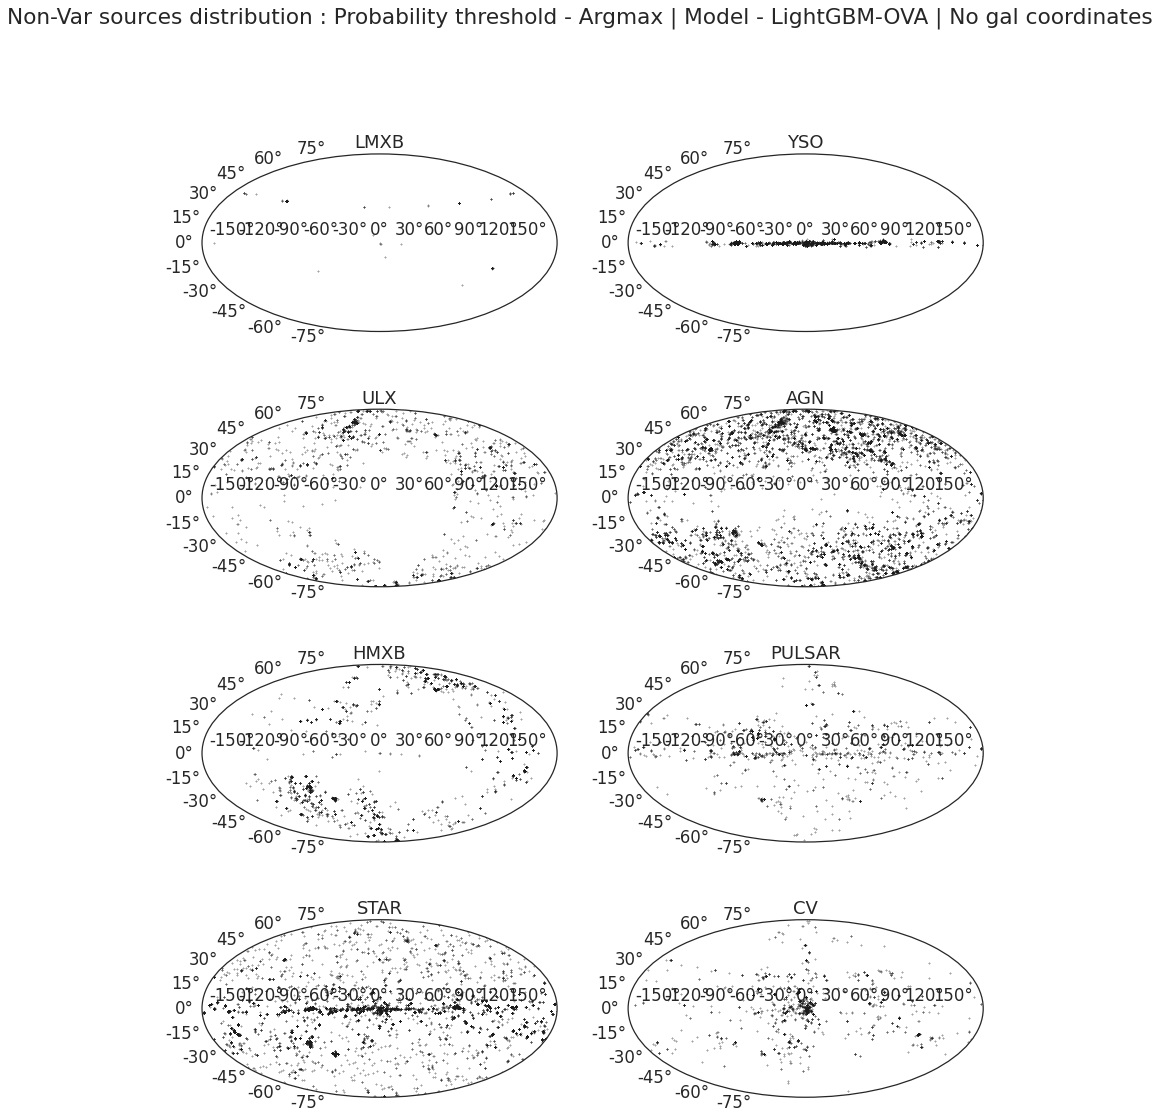

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
#plt.savefig('plots/all_src_pred/lightgbm_non-var.jpg')
plt.show()

In [12]:
u_df

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J004829.5-732959  HMXB  0.854534     0.738966  0.006866  0.003271   
2CXO J005449.0-725128  HMXB  0.929717     0.885827  0.008875  0.016311   
2CXO J010049.1-731526  HMXB  0.807098     0.639931  0.008277  0.004818   
2CXO J010049.8-731045  HMXB  0.526201     0.118842  0.040766  0.016721   
2CXO J010647.7-730940  HMXB  0.683742     0.391823  0.004241  0.009808   
...                     ...       ...          ...       ...       ...   
2CXO J220433.1-495916  HMXB  0.671695     0.438401  0.032561  0.233294   
2CXO J220508.3-495935  HMXB  0.913425     0.850303  0.017150  0.063122   
2CXO J220544.0-495505  HMXB  0.801407     0.710030  0.089127  0.091377   
2CXO J220555.6-500837  HMXB  0.926816     0.864189  0.000871  0.008760   
2CXO J220603.1-500911  STAR  0.985432     0.971931  0.000290  0.000290   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J004829.5-732959   0.854534   0.000017     0.002261   0.115568  0.017461   
2CXO J005449.0-725128   0.929717   0.000043     0.000785   0.043891  0.000347   
2CXO J010049.1-731526   0.807098   0.000054     0.005160   0.167167  0.007402   
2CXO J010049.8-731045   0.526201   0.000443     0.003861   0.407359  0.004558   
2CXO J010647.7-730940   0.683742   0.002000     0.008044   0.291919  0.000168   
...                          ...        ...          ...        ...       ...   
2CXO J220433.1-495916   0.671695   0.000025     0.000336   0.007829  0.054160   
2CXO J220508.3-495935   0.913425   0.000210     0.000860   0.001775  0.003403   
2CXO J220544.0-495505   0.801407   0.000579     0.000613   0.013682  0.003008   
2CXO J220555.6-500837   0.926816   0.000044     0.000296   0.000558  0.062627   
2CXO J220603.1-500911   0.013500   0.000054     0.000343   0.985432  0.000040   

                       prob_YSO  
name                             
2CXO J004829.5-732959  0.000021  
2CXO J005449.0-725128  0.000032  
2CXO J010049.1-731526  0.000025  
2CXO J010049.8-731045  0.000092  
2CXO J010647.7-730940  0.000077  
...                         ...  
2CXO J220433.1-495916  0.000100  
2CXO J220508.3-495935  0.000054  
2CXO J220544.0-495505  0.000208  
2CXO J220555.6-500837  0.000027  
2CXO J220603.1-500911  0.000051  

[37873 rows x 11 columns]

In [11]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                #u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                #u_df[u_df['prob']>0.6]['class'].value_counts(),
                #u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                #u_df[u_df['prob']>0.9]['class'].value_counts(),
                u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax'  ,'0.5' , '0.8'  ,  f"0.98"]
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   0.5 |   0.8 |   0.98 |
|:--------|---------:|------:|------:|-------:|
| AGN     |    10937 | 10348 |  8332 |   5350 |
| STAR    |     9511 |  9100 |  7215 |   4882 |
| YSO     |     8809 |  8678 |  7185 |   3887 |
| HMXB    |     3030 |  2655 |  1593 |    626 |
| ULX     |     2273 |  1959 |  1035 |    208 |
| CV      |     1791 |  1456 |   731 |    165 |
| PULSAR  |     1380 |  1079 |   496 |     71 |
| LMXB    |      142 |   136 |   121 |     94 |


In [27]:
print(u_df_num.to_latex(bold_rows=True))

\begin{tabular}{lrrrr}
\toprule
{} &  Argmax &    0.5 &   0.8 &  0.98 \\
\textbf{class } &         &        &       &       \\
\midrule
\textbf{AGN   } &   10937 &  10348 &  8332 &  5350 \\
\textbf{STAR  } &    9511 &   9100 &  7215 &  4882 \\
\textbf{YSO   } &    8809 &   8678 &  7185 &  3887 \\
\textbf{HMXB  } &    3030 &   2655 &  1593 &   626 \\
\textbf{ULX   } &    2273 &   1959 &  1035 &   208 \\
\textbf{CV    } &    1791 &   1456 &   731 &   165 \\
\textbf{PULSAR} &    1380 &   1079 &   496 &    71 \\
\textbf{LMXB  } &     142 &    136 &   121 &    94 \\
\bottomrule
\end{tabular}



In [28]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
#cl.remove('LMXB')
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

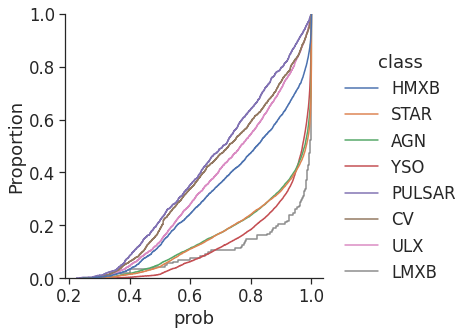

In [29]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()

In [30]:
u_conf = u[u_df['prob']>0.98]
u_conf

gal_b2    gal_l2  var_inter_prob_b  \
name                                                          
2CXO J011132.4-730210  2.539434  8.358207               NaN   
2CXO J012106.5-730352  2.546208  8.331692               NaN   
2CXO J165038.2-433554  5.026490  9.491185               NaN   
2CXO J171052.0-393315  4.999021  9.644353               NaN   
2CXO J171104.3-393951  4.993618  9.642535               NaN   
...                         ...       ...               ...   
2CXO J060212.5-395227  3.546104  6.844886          5.975523   
2CXO J060228.9-400246  3.546502  6.850436          6.907320   
2CXO J060233.7-395610  3.548883  6.847263          9.888299   
2CXO J060239.5-395412  3.550345  6.846427          0.106946   
2CXO J220603.1-500911  2.144237  9.591859          9.994348   

                       var_inter_sigma_b  var_intra_prob_b  var_inter_index_b  \
name                                                                            
2CXO J011132.4-730210                NaN          0.687469                NaN   
2CXO J012106.5-730352                NaN          0.881629                NaN   
2CXO J165038.2-433554                NaN          9.469891                NaN   
2CXO J171052.0-393315                NaN          9.480754                NaN   
2CXO J171104.3-393951                NaN         10.000000                NaN   
...                                  ...               ...                ...   
2CXO J060212.5-395227           0.000653          9.864978               5.00   
2CXO J060228.9-400246           0.001225         10.000000               6.25   
2CXO J060233.7-395610           0.002254         10.000000               7.50   
2CXO J060239.5-395412           0.000014          5.730256               0.00   
2CXO J220603.1-500911           0.015846          8.893080               8.75   

                       kp_intra_prob_b  var_intra_index_b         h-csc  \
name                                                                      
2CXO J011132.4-730210         0.686607                0.0  1.049425e-04   
2CXO J012106.5-730352         9.173512                0.0  1.539318e-07   
2CXO J165038.2-433554         9.807162                6.0  3.676157e-08   
2CXO J171052.0-393315         9.999759                6.0           NaN   
2CXO J171104.3-393951        10.000000                9.0  7.876697e-08   
...                                ...                ...           ...   
2CXO J060212.5-395227         9.984111                6.0  8.236682e-09   
2CXO J060228.9-400246        10.000000                9.0  2.192449e-09   
2CXO J060233.7-395610        10.000000                9.0  2.711781e-09   
2CXO J060239.5-395412         8.982621                1.0  1.992749e-08   
2CXO J220603.1-500911         9.995940                5.0  4.605293e-07   

                          b-csc  ...        Rp       B-R       G-J      G-W2  \
name                             ...                                           
2CXO J011132.4-730210  0.060486  ...       NaN       NaN       NaN       NaN   
2CXO J012106.5-730352  0.067567  ...       NaN       NaN       NaN       NaN   
2CXO J165038.2-433554  0.013108  ...  7.632290  4.226298  3.921825       NaN   
2CXO J171052.0-393315  0.008154  ...  5.695557  3.888696  2.846068  3.159264   
2CXO J171104.3-393951  0.025182  ...  8.181465  4.926246       NaN       NaN   
...                         ...  ...       ...       ...       ...       ...   
2CXO J060212.5-395227  0.001646  ...       NaN       NaN       NaN       NaN   
2CXO J060228.9-400246  0.007383  ...  6.002884  5.485637  3.811712       NaN   
2CXO J060233.7-395610  0.007225  ...  5.102440  4.712172  3.272828       NaN   
2CXO J060239.5-395412  0.005457  ...       NaN       NaN       NaN       NaN   
2CXO J220603.1-500911  0.032189  ...  5.896753  3.480289  2.341994       NaN   

                           Bp-H     Bp-W3      Rp-K       J-H      J-W1  \
name                                                       

In [31]:
from utilities import get_true_data 
x_true = get_true_data(x[[]])
x_true.insert(0 , 'class' , y.to_list())
x_true

class       gal_l      gal_b  var_flag         b-csc  \
name                                                                         
2CXO J002359.4-720438    CV  305.906836 -44.891974         0  4.876519e-16   
2CXO J174041.4-534004    CV  338.169913 -11.955034         0  7.740836e-14   
2CXO J002409.2-720543    CV  305.885422 -44.875913         1  2.562080e-15   
2CXO J002411.1-720620    CV  305.879929 -44.866347         1  7.164108e-15   
2CXO J002401.4-720441    CV  305.903006 -44.891458         0  5.271021e-16   
...                     ...         ...        ...       ...           ...   
2CXO J003444.5-431554   AGN  313.695278 -73.512446         0  1.760760e-14   
2CXO J203606.3+422737   YSO   81.460520   1.047461         0  1.075428e-14   
2CXO J131747.5+411745   AGN  103.694219  74.833112         0  6.363757e-14   
2CXO J023234.3-073105   AGN  178.312779 -59.034064         0  8.628525e-14   
2CXO J103357.8+574942   AGN  151.460729  50.997723         0  9.078517e-15   

                              h-csc         m-csc         s-csc         u-csc  \
name                                                                            
2CXO J002359.4-720438  1.147331e-16  9.684449e-17  4.182269e-16  3.833601e-16   
2CXO J174041.4-534004  2.860960e-15  1.362061e-14  6.016759e-14  2.457054e-14   
2CXO J002409.2-720543  1.642628e-15  5.098716e-16  5.844156e-16  1.720191e-16   
2CXO J002411.1-720620  5.196663e-15  9.022319e-16  1.346415e-15  1.707178e-16   
2CXO J002401.4-720441  0.000000e+00  1.315511e-16  5.195442e-16  2.535326e-16   
...                             ...           ...           ...           ...   
2CXO J003444.5-431554  1.266283e-14  1.875643e-15  3.722251e-15           NaN   
2CXO J203606.3+422737  9.460987e-15  1.197641e-15  0.000000e+00           NaN   
2CXO J131747.5+411745  2.008880e-14  1.407862e-14  3.137641e-14  1.851254e-14   
2CXO J023234.3-073105  2.335569e-14  3.193573e-14  3.202784e-14  7.849063e-14   
2CXO J103357.8+574942  6.024590e-15  1.286413e-15  1.686701e-15           NaN   

                        hard_hm  ...      bp-W3      rp-K    J-H   J-W1  \
name                             ...                                      
2CXO J002359.4-720438 -0.058713  ...        NaN  0.783199  0.447    NaN   
2CXO J174041.4-534004 -0.803248  ...        NaN       NaN    NaN    NaN   
2CXO J002409.2-720543  0.089944  ...        NaN       NaN    NaN    NaN   
2CXO J002411.1-720620  0.292317  ...        NaN       NaN    NaN    NaN   
2CXO J002401.4-720441 -0.999375  ...        NaN       NaN    NaN    NaN   
...                         ...  ...        ...       ...    ...    ...   
2CXO J003444.5-431554  0.208620  ...        NaN       NaN    NaN    NaN   
2CXO J203606.3+422737  0.605871  ...  12.700336  5.438294  1.555  2.427   
2CXO J131747.5+411745 -0.188632  ...   8.397534       NaN    NaN    NaN   
2CXO J023234.3-073105 -0.114928  ...   8.010382  2.101692  0.044  2.816   
2CXO J103357.8+574942  0.184884  ...        NaN       NaN    NaN    NaN   

                       W1-W2    u-g    g-r    r-z    i-z    u-z  
name                                                             
2CXO J002359.4-720438    NaN    NaN    NaN    NaN    NaN    NaN  
2CXO J174041.4-534004    NaN    NaN    NaN    NaN    NaN    NaN  
2CXO J002409.2-720543    NaN    NaN    NaN    NaN    NaN    NaN  
2CXO J002411.1-720620    NaN    NaN    NaN    NaN    NaN    NaN  
2CXO J002401.4-720441    NaN    NaN    NaN    NaN    NaN    NaN  
...                      ...    ...    ...    ...    ...    ...  
2CXO J003444.5-431554    NaN    NaN    NaN    NaN    NaN    NaN  
2CXO J203606.3+422737  0.287 -0.877  2.473  3.859  1.605  5.455  
2CXO J131747.5+411745  1.221  0.161  0.059  0.032  0.093  0.252  
2CXO J023234.3-073105  1.114  0.288  0.011  0.015  0.074  0.314  
2CXO J103357.8+574942    NaN  0.367  0.051  0.045  0.106  0.463  

[7703 rows x 50 columns]

In [32]:
u_conf_true = get_true_data(u_conf[[]])
u_conf_true 

gal_l      gal_b  var_flag         b-csc  \
name                                                                   
2CXO J011132.4-730210  300.895186 -44.012457         1  1.042125e-13   
2CXO J012106.5-730352  299.940632 -43.891049         1  1.298360e-13   
2CXO J165038.2-433554  341.682298   0.559407         1  2.193951e-14   
2CXO J171052.0-393315  347.196365   0.067130         1  1.469478e-14   
2CXO J171104.3-393951  347.130898  -0.029703         1  4.797124e-14   
...                           ...        ...       ...           ...   
2CXO J060212.5-395227  246.415695 -25.971375         1  2.790724e-15   
2CXO J060228.9-400246  246.615482 -25.964242         1  1.290098e-14   
2CXO J060233.7-395610  246.501256 -25.921571         1  1.380813e-14   
2CXO J060239.5-395412  246.471173 -25.895382         1  8.868943e-15   
2CXO J220603.1-500911  345.306558 -51.095003         1  5.560315e-14   

                              h-csc         m-csc         s-csc         u-csc  \
name                                                                            
2CXO J011132.4-730210  7.917335e-14  1.496702e-14  1.176121e-14  0.000000e+00   
2CXO J012106.5-730352  9.535171e-14  1.354135e-14  2.500571e-14  4.499523e-14   
2CXO J165038.2-433554  1.311442e-14  4.484770e-15  5.113546e-15  0.000000e+00   
2CXO J171052.0-393315  8.879304e-15  3.674367e-15  2.485074e-15           NaN   
2CXO J171104.3-393951  4.494135e-14  6.265503e-15  0.000000e+00           NaN   
...                             ...           ...           ...           ...   
2CXO J060212.5-395227  0.000000e+00  2.211620e-16  2.809164e-15  0.000000e+00   
2CXO J060228.9-400246  1.612563e-15  2.225967e-15  8.844946e-15  5.720756e-16   
2CXO J060233.7-395610  1.871696e-15  2.784018e-15  9.424609e-15  0.000000e+00   
2CXO J060239.5-395412  8.177129e-15  0.000000e+00  5.651346e-16  0.000000e+00   
2CXO J220603.1-500911  2.214651e-14  1.051337e-14  2.440629e-14  2.043089e-13   

                        hard_hm   hard_hs  ...  bp-W3  rp-K  J-H  J-W1  W1-W2  \
name                                       ...                                  
2CXO J011132.4-730210  0.154903  0.034978  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J012106.5-730352  0.054966 -0.444722  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J165038.2-433554  0.297314 -0.124922  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J171052.0-393315 -0.118676 -0.482199  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J171104.3-393951  0.216115  0.544660  ...    NaN   NaN  NaN   NaN    NaN   
...                         ...       ...  ...    ...   ...  ...   ...    ...   
2CXO J060212.5-395227 -0.023735 -0.999375  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J060228.9-400246 -0.503435 -0.878201  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J060233.7-395610 -0.495940 -0.873204  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J060239.5-395412  0.999375  0.594628  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J220603.1-500911 -0.011243 -0.552155  ...    NaN   NaN  NaN   NaN    NaN   

                       u-g  g-r  r-z  i-z  u-z  
name                                            
2CXO J011132.4-730210  NaN  NaN  NaN  NaN  NaN  
2CXO J012106.5-730352  NaN  NaN  NaN  NaN  NaN  
2CXO J165038.2-433554  NaN  NaN  NaN  NaN  NaN  
2CXO J171052.0-393315  NaN  NaN  NaN  NaN  NaN  
2CXO J171104.3-393951  NaN  NaN  NaN  NaN  NaN  
...                    ...  ...  ...  ...  ...  
2CXO J060212.5-395227  NaN  NaN  NaN  NaN  NaN  
2CXO J060228.9-400246  NaN  NaN  NaN  NaN  NaN  
2CXO J060233.7-395610  NaN  NaN  NaN  NaN  NaN  
2CXO J060239.5-395412  NaN  NaN  NaN  NaN  NaN  
2CXO J220603.1-500911  NaN  NaN  NaN  NaN  NaN  

[15283 rows x 49 columns]

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWar

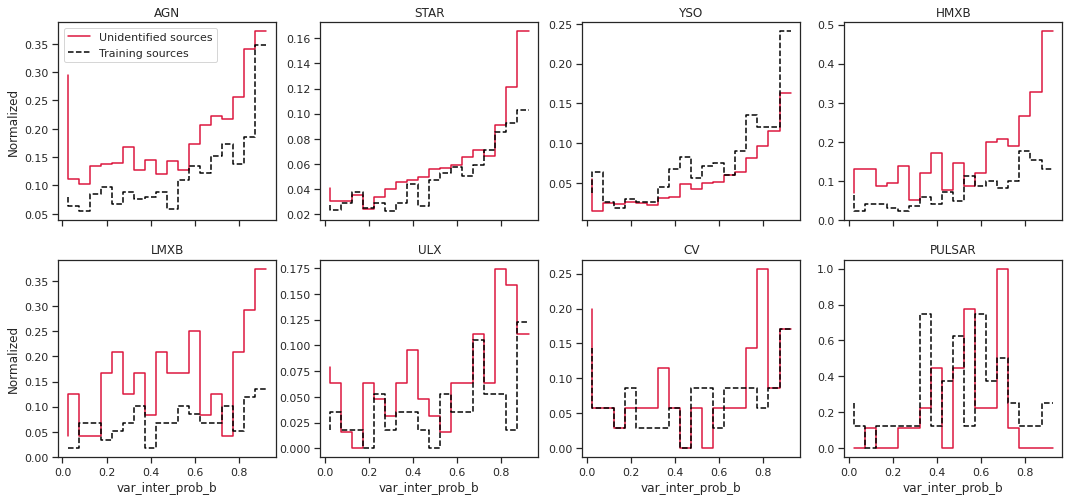

In [42]:
y_p = u_df['class']
cl = ['AGN' ,'STAR' , 'YSO' , 'HMXB' , 'LMXB' , 'ULX' ,'CV' ,'PULSAR']
sns.set(font_scale=1, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")
f = 'kp_intra_prob_b'
f = 'var_inter_prob_b'
from utilities import set_plot
#set_plot(font_size=1.5)
fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(18,8) , sharex='col' , sharey = False )
#plt.hist(x['kp_intra_prob_b'])
cl = np.reshape(cl , ax.shape)
bins = 20
for i in range(2):
    for j in range(4):
        temp = u_conf_true[y_p==cl[i][j]]
        count , x =  np.histogram(temp[f] , bins=bins , range = (0,1))
        xm = []
        for k in range(len(x)-1):
            xm.append((x[k]+x[k+1])/2)
        count = count / np.amax(count)
        xm = xm[:-1]
        count = count[:-1]
        ax[i][j].step(xm,count , label = 'Unidentified sources' , color='crimson' )
        temp = x_true[y==cl[i][j]]
        #display(temp)
        count , x =  np.histogram(temp[f] , bins=bins , range = (0,1))
        xm = []
        for k in range(len(x)-1):
            xm.append((x[k]+x[k+1])/2)
        count = count / np.amax(count)
        xm = xm[:-1]
        count = count[:-1]
        ax[i][j].step(xm , count ,'--' ,label = 'Training sources' , color='black',  )
        ax[i][j].set_title(cl[i][j])
        #ax[i][j].legend()
        #ax[i][j].set_ylabel('Normalized counts')
        #ax[i][j].set_xlabel('var_intra_prob_b')
for a in ax[:,0]:
    a.set_ylabel('Normalized')
ax[1][0].set_xlabel(f)
ax[1][1].set_xlabel(f)
ax[1][2].set_xlabel(f)
ax[1][3].set_xlabel(f)
ax[0][0].legend()
plt.savefig(f'{img_loc}/var-src-hist.jpg' , format='jpg')
plt.show()

In [43]:
u_conf_true[['var_inter_prob_b']]

var_inter_prob_b
name                                   
2CXO J011132.4-730210               NaN
2CXO J012106.5-730352               NaN
2CXO J165038.2-433554               NaN
2CXO J171052.0-393315               NaN
2CXO J171104.3-393951               NaN
...                                 ...
2CXO J060212.5-395227          0.597552
2CXO J060228.9-400246          0.690732
2CXO J060233.7-395610          0.988830
2CXO J060239.5-395412          0.010695
2CXO J220603.1-500911          0.999435

[15283 rows x 1 columns]

In [44]:
x_true[['var_inter_prob_b']]

var_inter_prob_b
name                                   
2CXO J002359.4-720438          0.263263
2CXO J174041.4-534004          1.000000
2CXO J002409.2-720543          0.999984
2CXO J002411.1-720620          0.830231
2CXO J002401.4-720441          0.500566
...                                 ...
2CXO J003444.5-431554               NaN
2CXO J203606.3+422737               NaN
2CXO J131747.5+411745               NaN
2CXO J023234.3-073105               NaN
2CXO J103357.8+574942          0.267174

[7703 rows x 1 columns]

In [45]:
u_df[u_df['prob']>0.98]['class'].value_counts()

AGN       5350
STAR      4882
YSO       3887
HMXB       626
ULX        208
CV         165
LMXB        94
PULSAR      71
Name: class, dtype: int64

In [46]:
u_df_conf = u_df[u_df['prob']>0.98]

In [47]:
t = y.value_counts().to_frame(name='train')
u = u_df_conf['class'].value_counts().to_frame(name='unid')
data = pd.concat([t,u], axis=1)
data.index.name = 'class'
data

train  unid
class              
STAR     2790  4882
AGN      2395  5350
YSO      1149  3887
HMXB      748   626
ULX       211   208
CV        166   165
LMXB      143    94
PULSAR    101    71

In [48]:
            
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = 'white'
color_red = 'crimson'
color_blue = 'k'
index = data.index
column0 = data['train']
column1 = data['unid']
title0 = 'Training Sources'
title1 = 'Unidentified sources'

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


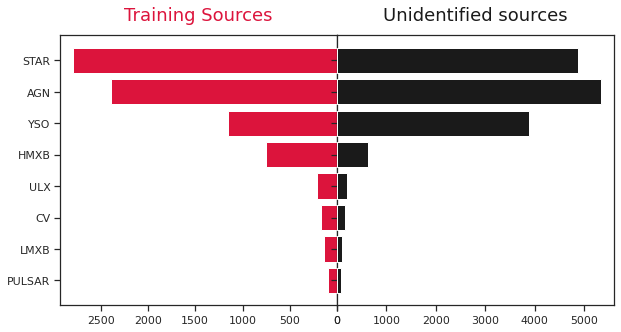

In [49]:

              
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()          
axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)
axes[0].invert_xaxis() 
plt.gca().invert_yaxis()
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
#plt.savefig('final_plots/var-src-num.eps' , format='eps')
plt.savefig(f'{img_loc}var-src-num.jpg' , format='jpg')
plt.show()

### PLot features

In [50]:
u_df

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J004829.5-732959  HMXB  0.854534     0.738966  0.006866  0.003271   
2CXO J005449.0-725128  HMXB  0.929717     0.885827  0.008875  0.016311   
2CXO J010049.1-731526  HMXB  0.807098     0.639931  0.008277  0.004818   
2CXO J010049.8-731045  HMXB  0.526201     0.118842  0.040766  0.016721   
2CXO J010647.7-730940  HMXB  0.683742     0.391823  0.004241  0.009808   
...                     ...       ...          ...       ...       ...   
2CXO J220433.1-495916  HMXB  0.671695     0.438401  0.032561  0.233294   
2CXO J220508.3-495935  HMXB  0.913425     0.850303  0.017150  0.063122   
2CXO J220544.0-495505  HMXB  0.801407     0.710030  0.089127  0.091377   
2CXO J220555.6-500837  HMXB  0.926816     0.864189  0.000871  0.008760   
2CXO J220603.1-500911  STAR  0.985432     0.971931  0.000290  0.000290   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J004829.5-732959   0.854534   0.000017     0.002261   0.115568  0.017461   
2CXO J005449.0-725128   0.929717   0.000043     0.000785   0.043891  0.000347   
2CXO J010049.1-731526   0.807098   0.000054     0.005160   0.167167  0.007402   
2CXO J010049.8-731045   0.526201   0.000443     0.003861   0.407359  0.004558   
2CXO J010647.7-730940   0.683742   0.002000     0.008044   0.291919  0.000168   
...                          ...        ...          ...        ...       ...   
2CXO J220433.1-495916   0.671695   0.000025     0.000336   0.007829  0.054160   
2CXO J220508.3-495935   0.913425   0.000210     0.000860   0.001775  0.003403   
2CXO J220544.0-495505   0.801407   0.000579     0.000613   0.013682  0.003008   
2CXO J220555.6-500837   0.926816   0.000044     0.000296   0.000558  0.062627   
2CXO J220603.1-500911   0.013500   0.000054     0.000343   0.985432  0.000040   

                       prob_YSO  
name                             
2CXO J004829.5-732959  0.000021  
2CXO J005449.0-725128  0.000032  
2CXO J010049.1-731526  0.000025  
2CXO J010049.8-731045  0.000092  
2CXO J010647.7-730940  0.000077  
...                         ...  
2CXO J220433.1-495916  0.000100  
2CXO J220508.3-495935  0.000054  
2CXO J220544.0-495505  0.000208  
2CXO J220555.6-500837  0.000027  
2CXO J220603.1-500911  0.000051  

[37873 rows x 11 columns]

In [51]:
u_true

gal_l      gal_b  var_flag         b-csc  \
name                                                                   
2CXO J004829.5-732959  303.220840 -43.626698         1  0.000000e+00   
2CXO J005449.0-725128  302.584181 -44.267982         1  1.459635e-14   
2CXO J010049.1-731526  301.995228 -43.853723         1  9.077404e-15   
2CXO J010049.8-731045  301.988531 -43.931660         1  1.863584e-14   
2CXO J010647.7-730940  301.388688 -43.921026         1  4.672140e-15   
...                           ...        ...       ...           ...   
2CXO J220433.1-495916  345.685712 -50.926635         1  0.000000e+00   
2CXO J220508.3-495935  345.626202 -51.013233         1  7.950968e-14   
2CXO J220544.0-495505  345.685626 -51.129040         1  4.094353e-14   
2CXO J220555.6-500837  345.331805 -51.079654         1  4.914482e-14   
2CXO J220603.1-500911  345.306558 -51.095003         1  5.560315e-14   

                              h-csc         m-csc         s-csc         u-csc  \
name                                                                            
2CXO J004829.5-732959  0.000000e+00  3.665415e-15  2.618477e-15  0.000000e+00   
2CXO J005449.0-725128  1.186815e-14  3.500941e-15  1.065828e-15           NaN   
2CXO J010049.1-731526  0.000000e+00  2.699734e-15  1.930347e-15  0.000000e+00   
2CXO J010049.8-731045  1.806768e-14  3.591089e-15  0.000000e+00  0.000000e+00   
2CXO J010647.7-730940  0.000000e+00  2.696803e-15  1.893618e-15  0.000000e+00   
...                             ...           ...           ...           ...   
2CXO J220433.1-495916  0.000000e+00  3.054163e-15  5.783170e-15  1.132957e-13   
2CXO J220508.3-495935  6.460030e-14  4.483764e-15  1.449362e-14  3.394314e-14   
2CXO J220544.0-495505  3.305450e-14  1.465739e-15  7.920010e-15           NaN   
2CXO J220555.6-500837  2.855748e-14  9.903589e-15  1.233885e-14  3.111881e-15   
2CXO J220603.1-500911  2.214651e-14  1.051337e-14  2.440629e-14  2.043089e-13   

                        hard_hm   hard_hs  ...  bp-W3  rp-K  J-H  J-W1  W1-W2  \
name                                       ...                                  
2CXO J004829.5-732959 -0.233604 -0.296065  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J005449.0-725128  0.382261  0.438476  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J010049.1-731526 -0.999375 -0.999375  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J010049.8-731045  0.404747  0.999375  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J010647.7-730940 -0.999375 -0.999375  ...    NaN   NaN  NaN   NaN    NaN   
...                         ...       ...  ...    ...   ...  ...   ...    ...   
2CXO J220433.1-495916  0.557152 -0.775765  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J220508.3-495935  0.503435  0.021237  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J220544.0-495505  0.678326  0.131168  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J220555.6-500837  0.088695 -0.204872  ...    NaN   NaN  NaN   NaN    NaN   
2CXO J220603.1-500911 -0.011243 -0.552155  ...    NaN   NaN  NaN   NaN    NaN   

                       u-g  g-r  r-z  i-z  u-z  
name                                            
2CXO J004829.5-732959  NaN  NaN  NaN  NaN  NaN  
2CXO J005449.0-725128  NaN  NaN  NaN  NaN  NaN  
2CXO J010049.1-731526  NaN  NaN  NaN  NaN  NaN  
2CXO J010049.8-731045  NaN  NaN  NaN  NaN  NaN  
2CXO J010647.7-730940  NaN  NaN  NaN  NaN  NaN  
...                    ...  ...  ...  ...  ...  
2CXO J220433.1-495916  NaN  NaN  NaN  NaN  NaN  
2CXO J220508.3-495935  NaN  NaN  NaN  NaN  NaN  
2CXO J220544.0-495505  NaN  NaN  NaN  NaN  NaN  
2CXO J220555.6-500837  NaN  NaN  NaN  NaN  NaN  
2CXO J220603.1-500911  NaN  NaN  NaN  NaN  NaN  

[39893 rows x 49 columns]

In [52]:
u_true_pred = pd.merge(u_df , u_true , left_index =True , right_index =True)
u_true_pred

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J004829.5-732959  HMXB  0.854534     0.738966  0.006866  0.003271   
2CXO J005449.0-725128  HMXB  0.929717     0.885827  0.008875  0.016311   
2CXO J010049.1-731526  HMXB  0.807098     0.639931  0.008277  0.004818   
2CXO J010049.8-731045  HMXB  0.526201     0.118842  0.040766  0.016721   
2CXO J010647.7-730940  HMXB  0.683742     0.391823  0.004241  0.009808   
...                     ...       ...          ...       ...       ...   
2CXO J220433.1-495916  HMXB  0.671695     0.438401  0.032561  0.233294   
2CXO J220508.3-495935  HMXB  0.913425     0.850303  0.017150  0.063122   
2CXO J220544.0-495505  HMXB  0.801407     0.710030  0.089127  0.091377   
2CXO J220555.6-500837  HMXB  0.926816     0.864189  0.000871  0.008760   
2CXO J220603.1-500911  STAR  0.985432     0.971931  0.000290  0.000290   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J004829.5-732959   0.854534   0.000017     0.002261   0.115568  0.017461   
2CXO J005449.0-725128   0.929717   0.000043     0.000785   0.043891  0.000347   
2CXO J010049.1-731526   0.807098   0.000054     0.005160   0.167167  0.007402   
2CXO J010049.8-731045   0.526201   0.000443     0.003861   0.407359  0.004558   
2CXO J010647.7-730940   0.683742   0.002000     0.008044   0.291919  0.000168   
...                          ...        ...          ...        ...       ...   
2CXO J220433.1-495916   0.671695   0.000025     0.000336   0.007829  0.054160   
2CXO J220508.3-495935   0.913425   0.000210     0.000860   0.001775  0.003403   
2CXO J220544.0-495505   0.801407   0.000579     0.000613   0.013682  0.003008   
2CXO J220555.6-500837   0.926816   0.000044     0.000296   0.000558  0.062627   
2CXO J220603.1-500911   0.013500   0.000054     0.000343   0.985432  0.000040   

                       ...  bp-W3  rp-K  J-H  J-W1  W1-W2  u-g  g-r  r-z  i-z  \
name                   ...                                                      
2CXO J004829.5-732959  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J005449.0-725128  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J010049.1-731526  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J010049.8-731045  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J010647.7-730940  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
...                    ...    ...   ...  ...   ...    ...  ...  ...  ...  ...   
2CXO J220433.1-495916  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220508.3-495935  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220544.0-495505  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220555.6-500837  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220603.1-500911  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   

                       u-z  
name                        
2CXO J004829.5-732959  NaN  
2CXO J005449.0-725128  NaN  
2CXO J010049.1-731526  NaN  
2CXO J010049.8-731045  NaN  
2CXO J010647.7-730940  NaN  
...                    ...  
2CXO J220433.1-495916  NaN  
2CXO J220508.3-495935  NaN  
2CXO J220544.0-495505  NaN  
2CXO J220555.6-500837  NaN  
2CXO J220603.1-500911  NaN  

[37873 rows x 60 columns]

In [53]:
u_true_pred

class      prob  prob_margin  prob_AGN   prob_CV  \
name                                                                     
2CXO J004829.5-732959  HMXB  0.854534     0.738966  0.006866  0.003271   
2CXO J005449.0-725128  HMXB  0.929717     0.885827  0.008875  0.016311   
2CXO J010049.1-731526  HMXB  0.807098     0.639931  0.008277  0.004818   
2CXO J010049.8-731045  HMXB  0.526201     0.118842  0.040766  0.016721   
2CXO J010647.7-730940  HMXB  0.683742     0.391823  0.004241  0.009808   
...                     ...       ...          ...       ...       ...   
2CXO J220433.1-495916  HMXB  0.671695     0.438401  0.032561  0.233294   
2CXO J220508.3-495935  HMXB  0.913425     0.850303  0.017150  0.063122   
2CXO J220544.0-495505  HMXB  0.801407     0.710030  0.089127  0.091377   
2CXO J220555.6-500837  HMXB  0.926816     0.864189  0.000871  0.008760   
2CXO J220603.1-500911  STAR  0.985432     0.971931  0.000290  0.000290   

                       prob_HMXB  prob_LMXB  prob_PULSAR  prob_STAR  prob_ULX  \
name                                                                            
2CXO J004829.5-732959   0.854534   0.000017     0.002261   0.115568  0.017461   
2CXO J005449.0-725128   0.929717   0.000043     0.000785   0.043891  0.000347   
2CXO J010049.1-731526   0.807098   0.000054     0.005160   0.167167  0.007402   
2CXO J010049.8-731045   0.526201   0.000443     0.003861   0.407359  0.004558   
2CXO J010647.7-730940   0.683742   0.002000     0.008044   0.291919  0.000168   
...                          ...        ...          ...        ...       ...   
2CXO J220433.1-495916   0.671695   0.000025     0.000336   0.007829  0.054160   
2CXO J220508.3-495935   0.913425   0.000210     0.000860   0.001775  0.003403   
2CXO J220544.0-495505   0.801407   0.000579     0.000613   0.013682  0.003008   
2CXO J220555.6-500837   0.926816   0.000044     0.000296   0.000558  0.062627   
2CXO J220603.1-500911   0.013500   0.000054     0.000343   0.985432  0.000040   

                       ...  bp-W3  rp-K  J-H  J-W1  W1-W2  u-g  g-r  r-z  i-z  \
name                   ...                                                      
2CXO J004829.5-732959  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J005449.0-725128  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J010049.1-731526  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J010049.8-731045  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J010647.7-730940  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
...                    ...    ...   ...  ...   ...    ...  ...  ...  ...  ...   
2CXO J220433.1-495916  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220508.3-495935  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220544.0-495505  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220555.6-500837  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   
2CXO J220603.1-500911  ...    NaN   NaN  NaN   NaN    NaN  NaN  NaN  NaN  NaN   

                       u-z  
name                        
2CXO J004829.5-732959  NaN  
2CXO J005449.0-725128  NaN  
2CXO J010049.1-731526  NaN  
2CXO J010049.8-731045  NaN  
2CXO J010647.7-730940  NaN  
...                    ...  
2CXO J220433.1-495916  NaN  
2CXO J220508.3-495935  NaN  
2CXO J220544.0-495505  NaN  
2CXO J220555.6-500837  NaN  
2CXO J220603.1-500911  NaN  

[37873 rows x 60 columns]

In [60]:
from utilities import plot_feat_feat
def plot_feat(params):
    classes = params['classes'] 
    prob_th = params['prob_th']  
    xq = params['x']
    yq1 = params['y1']
    yq2 = params['y2']
    xlabel = params['xlabel']
    ylabel1 = params['ylabel1']
    ylabel2 = params['ylabel2']
    fname = params['fname']
    #xq  , yq1 , yq2 =  'gmag' , 'bp-H' ,  'rp-K'
    sns.set(font_scale=1.2, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':False} , style="ticks")
    fig , ax =  plt.subplots(nrows=2 , ncols=2 , figsize=(16,10) , sharex=True, sharey='row')
    plot_feat_feat(x_true, xq,yq1 , ax=ax[0][0] , cl = classes)
    plot_feat_feat(u_true_pred[u_true_pred['prob']>prob_th], xq,yq1 ,  ax=ax[0][1] , cl = classes)
    plot_feat_feat(x_true, xq,yq2 , ax=ax[1][0] , cl = classes)
    plot_feat_feat(u_true_pred[u_true_pred['prob']>prob_th], xq,yq2 , ax=ax[1][1] , cl = classes)
    ax[0][0].legend(loc='upper left')
    ax[1][0].set_xlabel(xlabel)
    ax[1][1].set_xlabel(xlabel)
    ax[0][0].set_ylabel(ylabel1)
    ax[1][0].set_ylabel(ylabel2)
    ax[0][0].set_title("Sources in the training set")
    ax[0][1].set_title("New sources identified in this work")
    plt.subplots_adjust(wspace=0., hspace=0)
    if(fname):
        plt.savefig(fname)
    plt.show()

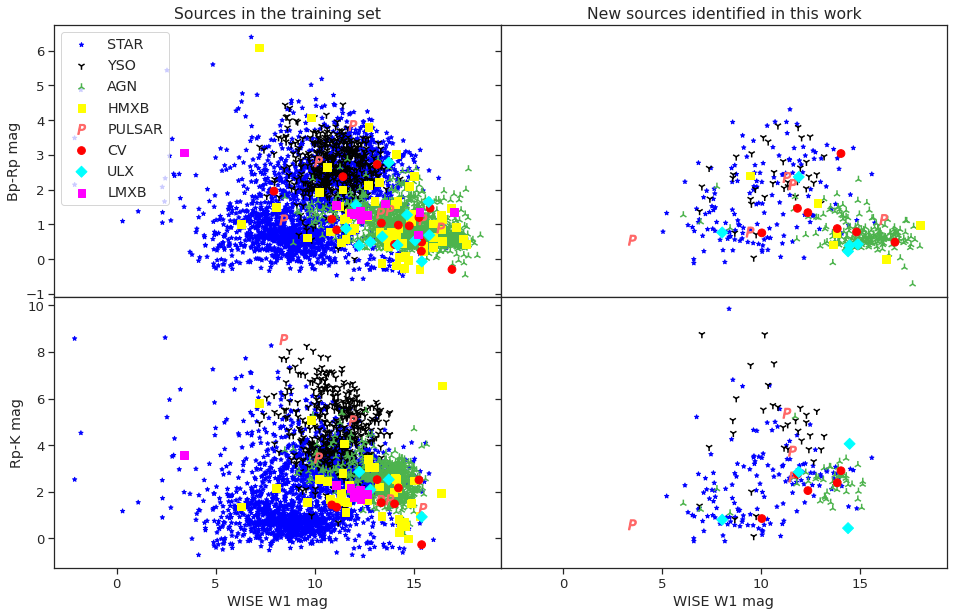

In [61]:
params = {
    'prob_th' : 0. , 
    'x' : 'W1mag' ,
    'y1' : 'bp-R' , 
    'y2' : 'rp-K'  ,
    'xlabel' : 'WISE W1 mag' , 
    'ylabel1' : 'Bp-Rp mag' , 
    'ylabel2' : 'Rp-K mag' , 
    'fname' : f'{img_loc}optical-ir-01-color.jpg' , 
    #'fname' : "" , 
    'classes' : ['STAR' ,'YSO', 'AGN', 'HMXB' ,'PULSAR' ,'CV' ,'ULX' , 'LMXB'] ,
}
plot_feat(params)

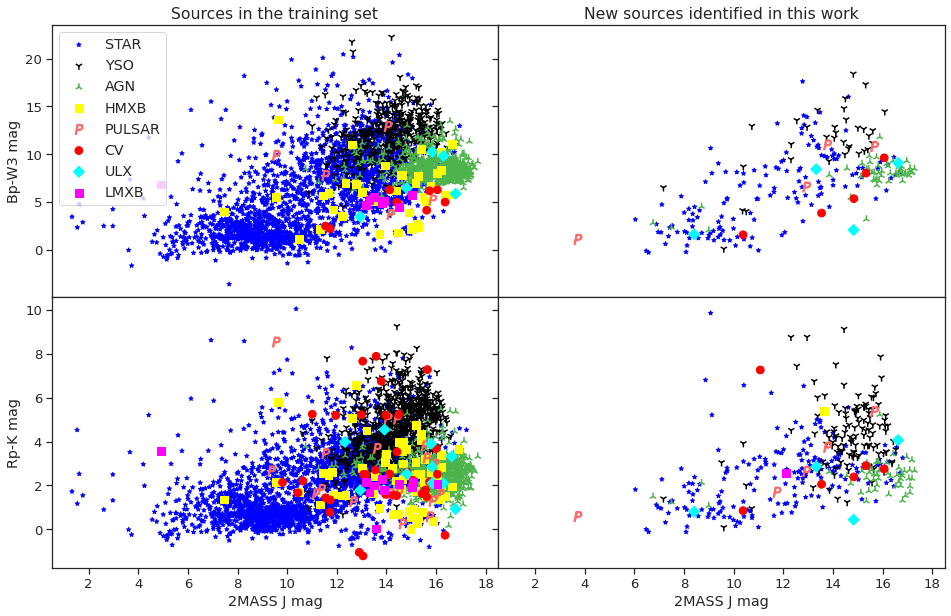

In [62]:
params = {
    'prob_th' : 0. , 
    'x' : 'Jmag' ,
    'y1' : 'bp-W3' , 
    'y2' : 'rp-K'  ,
    'xlabel' : '2MASS J mag' , 
    'ylabel1' : 'Bp-W3 mag' , 
    'ylabel2' : 'Rp-K mag' , 
    'fname' : f'{img_loc}optical-ir-02-color.jpg' , 
    #'fname' : "" , 
    'classes' : ['STAR' ,'YSO', 'AGN', 'HMXB' ,'PULSAR' ,'CV' ,'ULX' , 'LMXB'] ,
}
plot_feat(params)

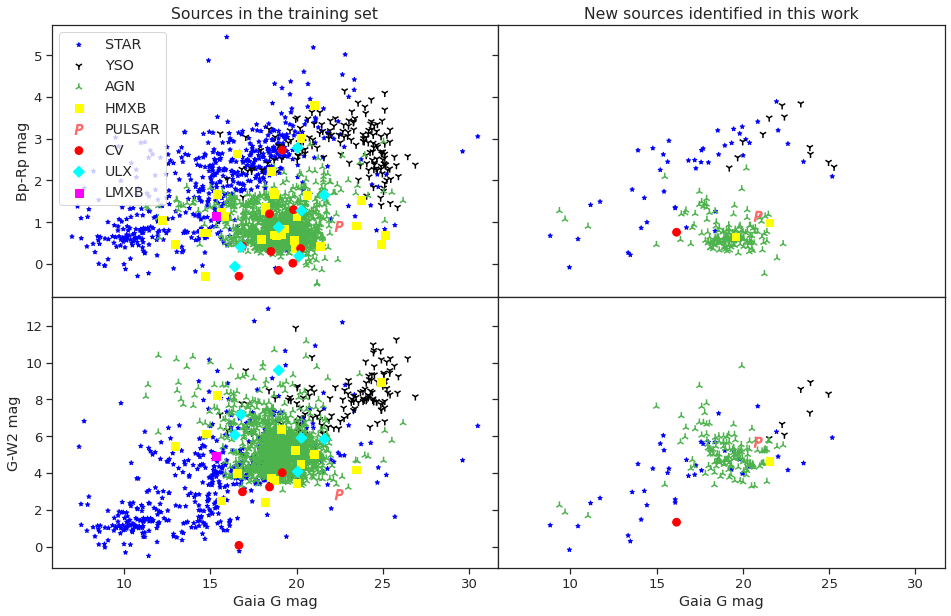

In [64]:
params = {
    'prob_th' : 0. , 
    'x' : 'gmag' ,
    'y1' : 'bp-R' , 
    'y2' : 'g-W2'  ,
    'xlabel' : 'Gaia G mag' , 
    'ylabel1' : 'Bp-Rp mag' , 
    'ylabel2' : 'G-W2 mag' , 
    'fname' : f'{img_loc}optical-ir-03-color.jpg' , 
    #'fname' : "" , 
    'classes' : ['STAR' ,'YSO', 'AGN', 'HMXB' ,'PULSAR' ,'CV' ,'ULX' , 'LMXB'] ,
}
plot_feat(params)

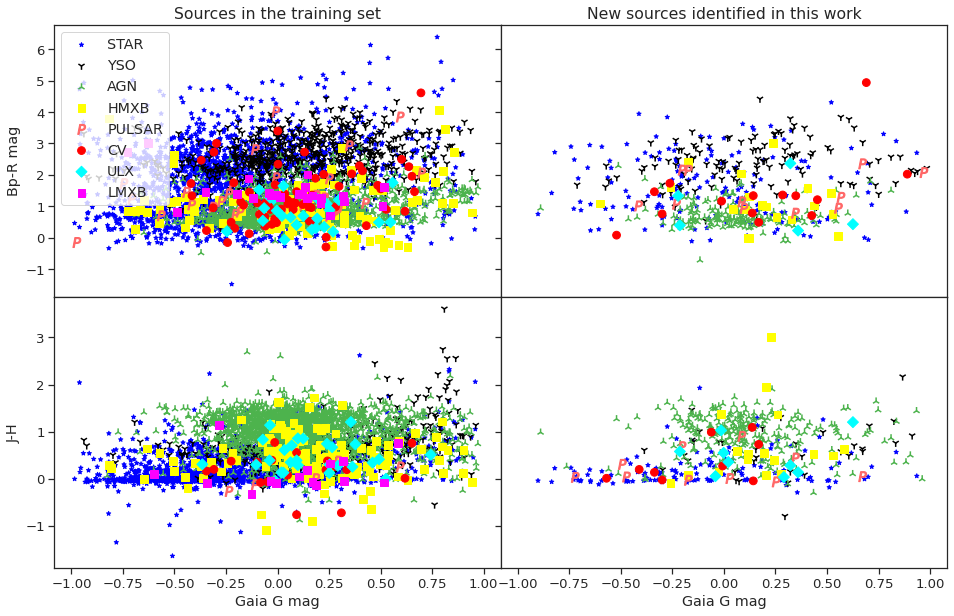

In [65]:
params = {
    'prob_th' : 0. , 
    'x' : 'hard_hm' ,
    'y1' : 'bp-R' , 
    'y2' : 'W1-W2'  ,
    'xlabel' : 'Gaia G mag' , 
    'ylabel1' : 'Bp-R mag' , 
    'ylabel2' : 'J-H' , 
    'fname' : f'{img_loc}optical-ir-04-color.jpg' , 
    'fname' : "" , 
    'classes' : ['STAR' ,'YSO', 'AGN', 'HMXB' ,'PULSAR' ,'CV' ,'ULX' , 'LMXB'] ,
}
plot_feat(params)

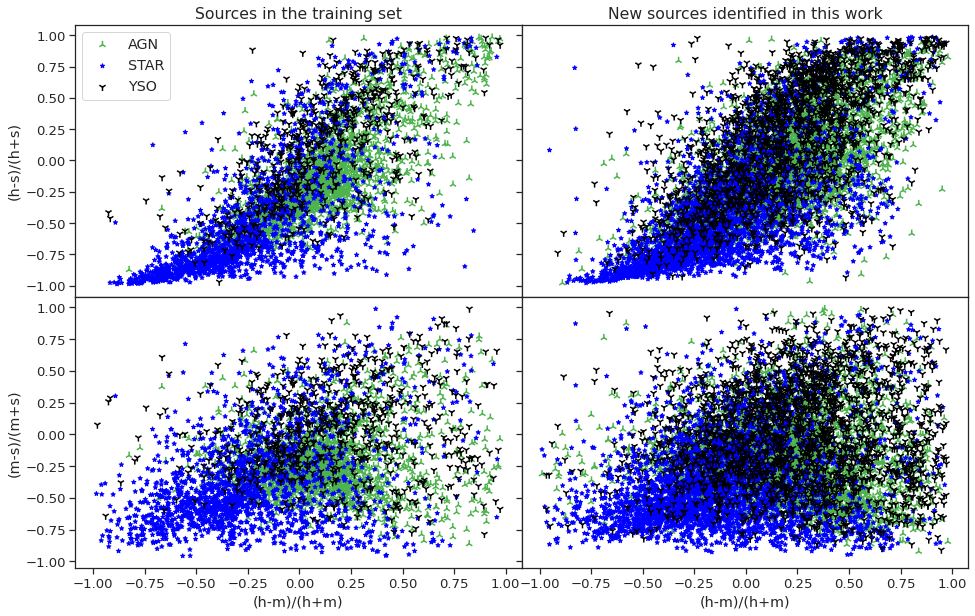

In [67]:
params = {
    'prob_th' : 0.98 , 
    'x' : 'hard_hm' ,
    'y1' : 'hard_hs' , 
    'y2' : 'hard_ms'  ,
    'xlabel' : '(h-m)/(h+m)' , 
    'ylabel1' : '(h-s)/(h+s)' , 
    'ylabel2' : '(m-s)/(m+s)' , 
    'fname' : f'{img_loc}x-hard-major-01.jpg' , 
    'classes' : ['AGN' , 'STAR' , 'YSO' ] ,
}
plot_feat(params)

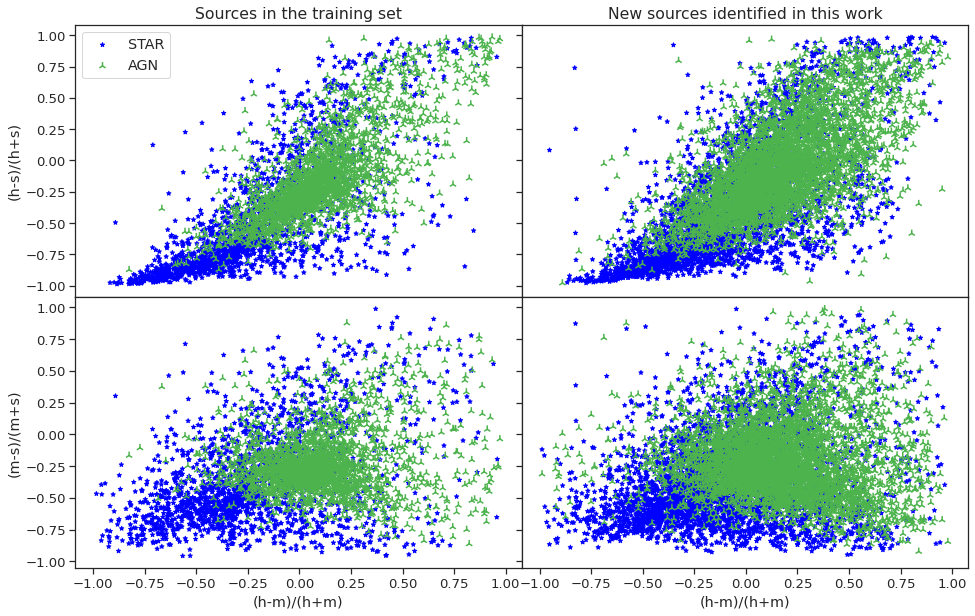

In [68]:
params = {
    'prob_th' : 0.98 , 
    'x' : 'hard_hm' ,
    'y1' : 'hard_hs' , 
    'y2' : 'hard_ms'  ,
    'xlabel' : '(h-m)/(h+m)' , 
    'ylabel1' : '(h-s)/(h+s)' , 
    'ylabel2' : '(m-s)/(m+s)' , 
    'fname' : f'{img_loc}x-hard-major-02.jpg' , 
    'classes' : ['STAR' , 'AGN' , ] ,
}
plot_feat(params)

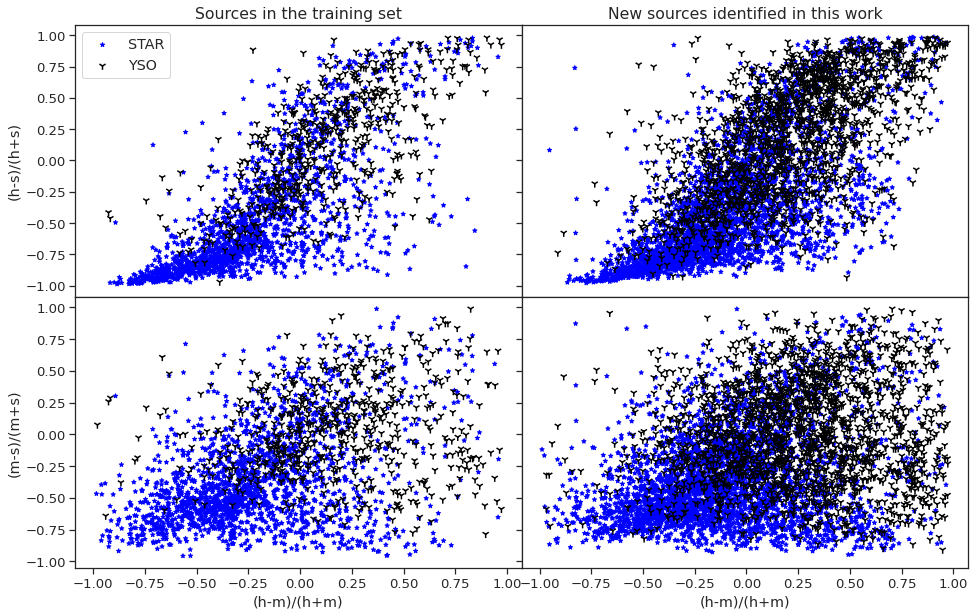

In [69]:
params = {
    'prob_th' : 0.98 , 
    'x' : 'hard_hm' ,
    'y1' : 'hard_hs' , 
    'y2' : 'hard_ms'  ,
    'xlabel' : '(h-m)/(h+m)' , 
    'ylabel1' : '(h-s)/(h+s)' , 
    'ylabel2' : '(m-s)/(m+s)' , 
    'fname' : f'{img_loc}x-hard-major-03.jpg' , 
    'classes' : ['STAR' , 'YSO' , ] ,
}
plot_feat(params)

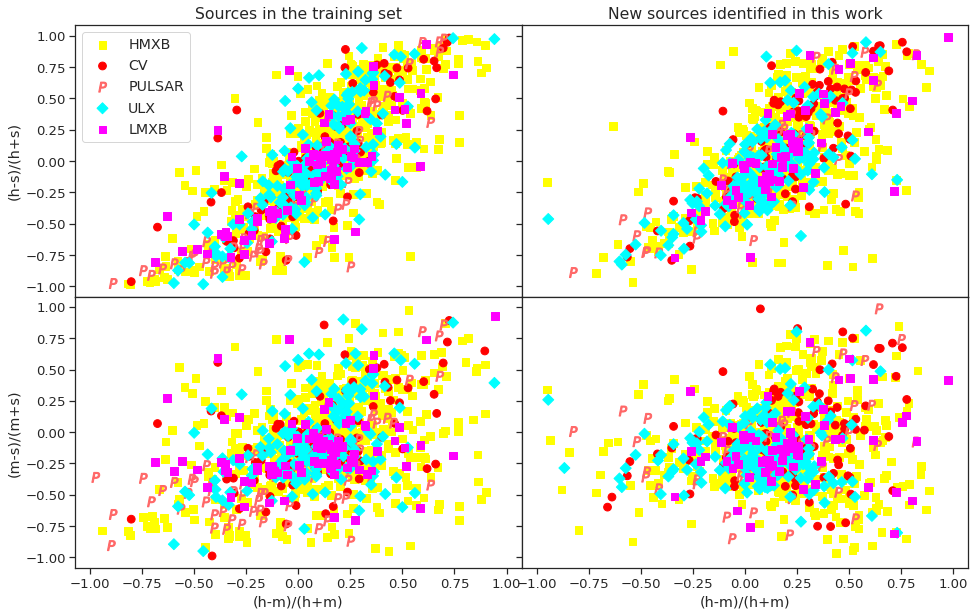

In [70]:
params = {
    'prob_th' : 0.98 , 
    'x' : 'hard_hm' ,
    'y1' : 'hard_hs' , 
    'y2' : 'hard_ms'  ,
    'xlabel' : '(h-m)/(h+m)' , 
    'ylabel1' : '(h-s)/(h+s)' , 
    'ylabel2' : '(m-s)/(m+s)' , 
    'fname' : f'{img_loc}x-hard-minor.jpg' , 
    'classes' : ['HMXB', 'CV' , 'PULSAR' ,'ULX' ,'LMXB' ] ,
}
plot_feat(params)

In [71]:
(len(u_true_pred) - u_true_pred.isna().sum(axis=0)).to_csv('temp_files/unid_src_data_available.csv')

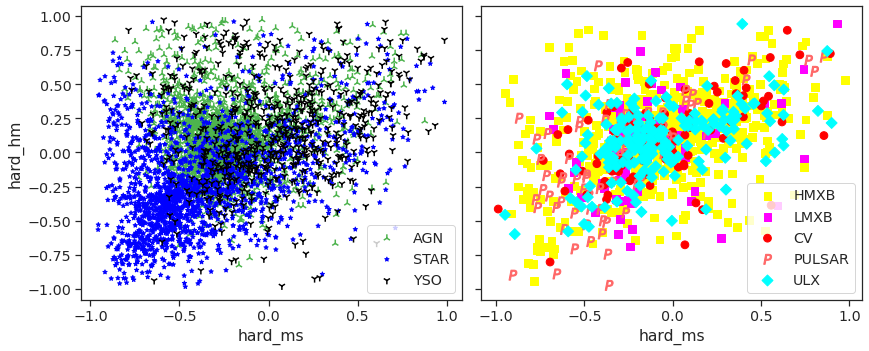

In [72]:
params = {
    'prob_th' : 0.98 , 
    'y' : 'hard_hm' ,
    'x1' : 'hard_hs' , 
    'x2' : 'hard_ms'  ,
    'xlabel' : '(h-m)/(h+m)' , 
    'ylabel1' : '(h-s)/(h+s)' , 
    'ylabel2' : '(m-s)/(m+s)' , 
    'fname' : 'final_plots/x-hard-minor.eps' , 
    'classes' : ['HMXB', 'CV' , 'PULSAR' ,'ULX' ,'LMXB' ] ,
}
fig , ax =  plt.subplots(nrows=1 , ncols=2 , figsize=(14,6) , sharey='row')
x1 = 'hard_ms'
x2 = 'hard_ms'
y = 'hard_hm'

plot_feat_feat(x_true, x1,y , ax=ax[0] , cl=['AGN' ,'STAR' , 'YSO'])
plot_feat_feat(x_true, x2,y , ax=ax[1] , cl = ['HMXB' , 'LMXB' , 'CV' , 'PULSAR' , 'ULX'])
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel(x1)
ax[0].set_ylabel(y)
ax[1].set_xlabel(x2)
#ax[0].set_xticklabels(rotation = 45, ha="right")
plt.subplots_adjust(wspace=0.05, hspace=0 , bottom=0.2)
plt.legend()
#plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(f'{img_loc}feat-1.jpg' , format='jpg')
plt.show()

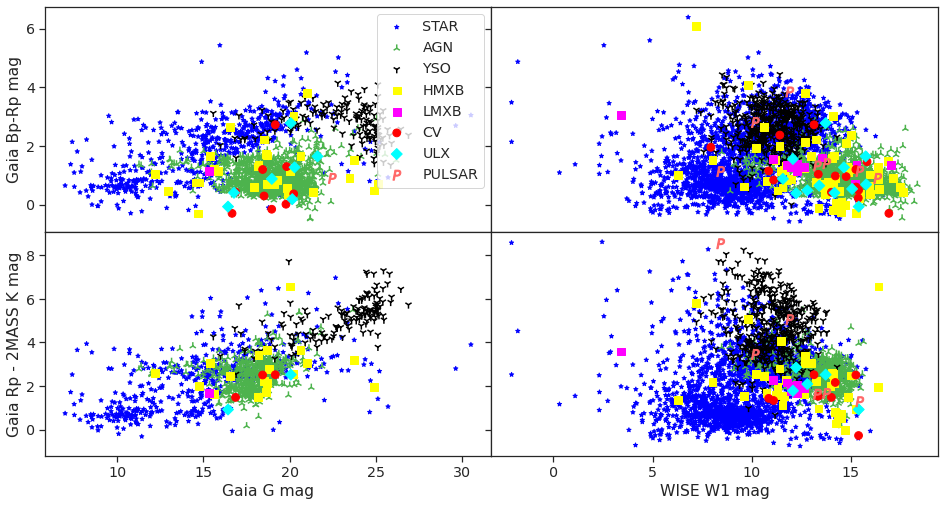

In [74]:
params = {
    'prob_th' : 0. , 
    'x' : 'gmag' ,
    'y1' : 'bp-R' , 
    'y2' : 'g-W2'  ,
    'xlabel' : 'Gaia G mag' , 
    'ylabel1' : 'Bp-Rp mag' , 
    'ylabel2' : 'G-W2 mag' , 
    'fname' : 'final_plots/optical-ir-03-color.eps' , 
    #'fname' : "" , 
    'classes' : ['STAR' ,'YSO', 'AGN', 'HMXB' ,'PULSAR' ,'CV' ,'ULX' , 'LMXB'] ,
}
fig , ax =  plt.subplots(nrows=2 , ncols=2 , figsize=(16,8) , sharey='row' , sharex='col')
x1 = 'gmag'
x2 = 'W1mag'
y1 = 'bp-R'
y2= 'rp-K'
plot_feat_feat(x_true, x1,y1 , ax=ax[0][0] ,)
plot_feat_feat(x_true, x2,y1 , ax=ax[0][1] ,)
plot_feat_feat(x_true, x1,y2 , ax=ax[1][0] ,)
plot_feat_feat(x_true, x2,y2 , ax=ax[1][1] ,)
ax[0][0].legend()
#ax[1].legend()
ax[0][0].set_ylabel("Gaia Bp-Rp mag")
ax[1][0].set_ylabel("Gaia Rp - 2MASS K mag")
ax[1][0].set_xlabel('Gaia G mag')
ax[1][1].set_xlabel('WISE W1 mag')
#ax[0].set_xticklabels(rotation = 45, ha="right")
plt.subplots_adjust(wspace=0.0, hspace=0 , bottom=0.2)
#plt.legend()
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig(f'{img_loc}feat-10.jpg' , format='jpg')
plt.show()

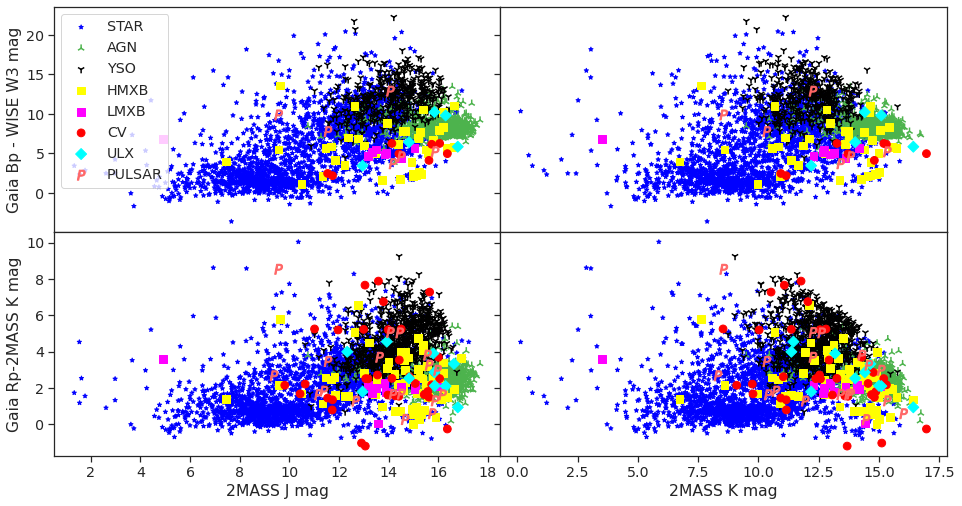

In [75]:
from utilities import set_plot
set_plot()
params = {
    'prob_th' : 0. , 
    'x' : 'gmag' ,
    'y1' : 'bp-R' , 
    'y2' : 'g-W2'  ,
    'xlabel' : 'Gaia G mag' , 
    'ylabel1' : 'Bp-Rp mag' , 
    'ylabel2' : 'G-W2 mag' , 
    'fname' : 'final_plots/optical-ir-03-color.eps' , 
    #'fname' : "" , 
    'classes' : ['STAR' ,'YSO', 'AGN', 'HMXB' ,'PULSAR' ,'CV' ,'ULX' , 'LMXB'] ,
}
fig , ax =  plt.subplots(nrows=2 , ncols=2 , figsize=(16,8) , sharey='row' , sharex='col')
x1 = 'Jmag'
x2 = 'Kmag'
y1 = 'bp-W3'
y2= 'rp-K'
plot_feat_feat(x_true, x1,y1 , ax=ax[0][0] ,)
plot_feat_feat(x_true, x2,y1 , ax=ax[0][1] ,)
plot_feat_feat(x_true, x1,y2 , ax=ax[1][0] ,)
plot_feat_feat(x_true, x2,y2 , ax=ax[1][1] ,)
ax[0][0].legend()
#ax[1].legend()
ax[0][0].set_ylabel("Gaia Bp - WISE W3 mag")
ax[1][0].set_ylabel("Gaia Rp-2MASS K mag")
ax[1][0].set_xlabel("2MASS J mag")
ax[1][1].set_xlabel("2MASS K mag")
#ax[0].set_xticklabels(rotation = 45, ha="right")
plt.subplots_adjust(wspace=0.0, hspace=0 , bottom=0.2)
#plt.legend()
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig(f'{img_loc}feat-11.jpg' , format='jpg')
plt.show()

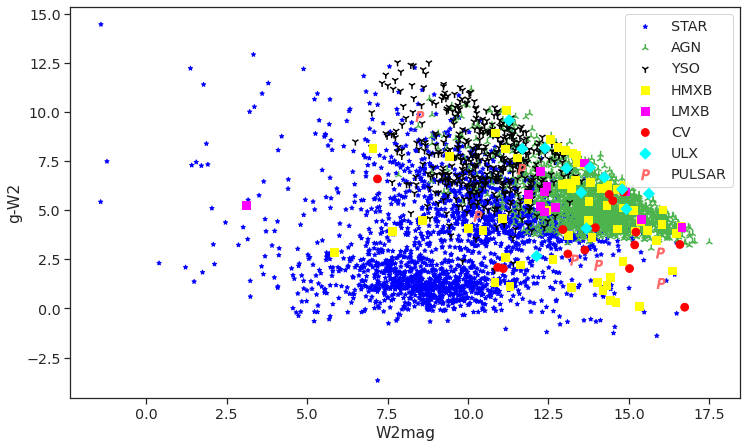

In [76]:

fig , ax =  plt.subplots(nrows=1 , ncols=1 , figsize=(12,8) , sharey='row')
x1 = 'W2mag'
y = 'g-W2'
#plot_feat_feat(x_true, x1,y , ax=ax[0] ,)
plot_feat_feat(x_true, x1,y , ax=ax ,)
ax.legend()
#ax[1].legend()
ax.set_xlabel(x1)
ax.set_ylabel(y)
#ax[1].set_xlabel(x2)
#ax[0].set_xticklabels(rotation = 45, ha="right")
plt.subplots_adjust(wspace=0.05, hspace=0 , bottom=0.2)
plt.legend()
#plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(f'{img_loc}feat-3.jpg' , format='jpg')
plt.show()

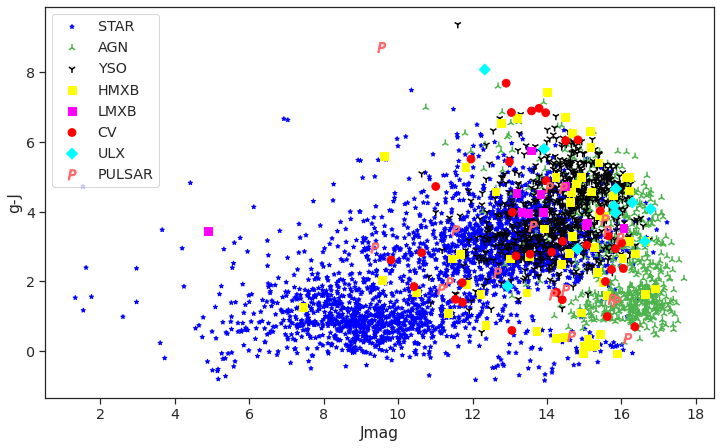

In [77]:

fig , ax =  plt.subplots(nrows=1 , ncols=1 , figsize=(12,8) , sharey='row')
#x1 = 'W2mag'
x2 = 'Jmag'
y = 'g-J'
#plot_feat_feat(x_true, x1,y , ax=ax[0] ,)
plot_feat_feat(x_true, x2,y , ax=ax ,)
ax.legend()
#ax[1].legend()
ax.set_xlabel(x2)
ax.set_ylabel(y)
#ax[1].set_xlabel(x2)
#ax[0].set_xticklabels(rotation = 45, ha="right")
plt.subplots_adjust(wspace=0.05, hspace=0 , bottom=0.2)
plt.legend()
#plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(f'{img_loc}feat-4.jpg' , format='jpg')
plt.show()

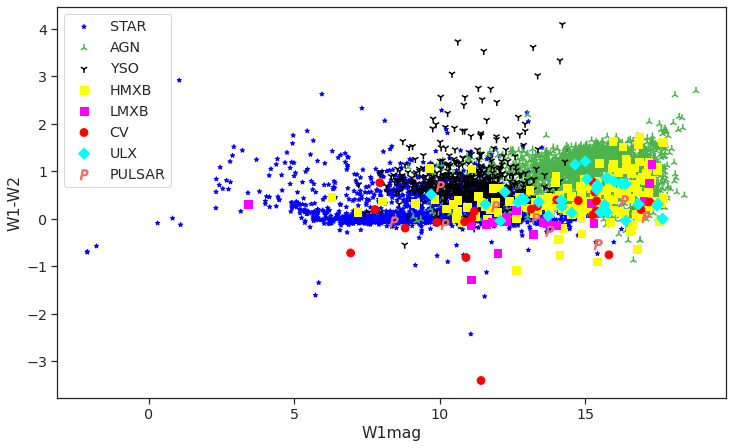

In [78]:

fig , ax =  plt.subplots(nrows=1 , ncols=1 , figsize=(12,8) , sharey='row')
#x1 = 'W2mag'
x2 = 'W1mag'
y = 'W1-W2'
#plot_feat_feat(x_true, x1,y , ax=ax[0] ,)
plot_feat_feat(x_true, x2,y , ax=ax ,)
ax.legend()
#ax[1].legend()
ax.set_xlabel(x2)
ax.set_ylabel(y)
#ax[1].set_xlabel(x2)
#ax[0].set_xticklabels(rotation = 45, ha="right")
plt.subplots_adjust(wspace=0.05, hspace=0 , bottom=0.2)
plt.legend()
#plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(f'{img_loc}feat-5.jpg' , format='jpg')
plt.show()